# Test build model

In [1]:
import tensorflow as tf
from keras import layers
from cnn_classifier import *

2023-03-06 16:25:13.302069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
input_shape = (128,128,3)
in_channels = 3
out_classes = 4
filters = [8,8,16,16,32,32,48,64,80]
kernel_size = [3,3,3,3,3,3,3,3,3]
strides = [1,2,1,2,1,2,1,1,1]
padding='valid'
activation='relu'
downsampling_mode='max'
flatten=False
fc=[128,16]
dropout = 0.5
spatial_dropout = 0.2
lambda_l2 = 0.0005
lrate = 0.001
loss = 'sparse_categorical_crossentropy'
metrics = None

In [3]:
model = create_cnn_classifier_network(input_shape, in_channels, out_classes, filters, kernel_size, strides, padding=padding, activation=activation, downsampling_mode=downsampling_mode, flatten=flatten, fc=fc)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         


2023-03-06 16:25:17.379375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
          

In [4]:
x = tf.random.normal((1,128,128,3))
y = model(x)
print(y)

tf.Tensor([[0.24320745 0.23275907 0.26992857 0.2541049 ]], shape=(1, 4), dtype=float32)


# Figures 1 & 2

In [5]:
import os
import fnmatch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [6]:
def read_all_rotations(dirname, filebase):
    '''Read results from dirname from files matching filebase'''
    
    # The set of files in the directory
    files = fnmatch.filter(os.listdir(dirname), filebase)
    files.sort()
    results = []
    
    # Loop over matching files
    for f in files:
        fp = open("%s/%s"%(dirname,f), "rb")
        r = pickle.load(fp)
        fp.close()
        results.append(r)
    return results

In [7]:
filebase = "image_Csize_3_3_3_3_3_Cfilters_10_20_30_40_50_Pool_2_2_2_2_2_Pad_valid_hidden_50_20_drop_0.500_L2_0.000500_LR_0.001000_ntrain_*_rot_*_results.pkl"
results = read_all_rotations("results", filebase)

In [8]:
print(len(results)) # should be 20*7 = 140 eventually
results[0].keys()

5


dict_keys(['args', 'predict_validation', 'predict_validation_eval', 'predict_testing', 'predict_testing_eval', 'predict_training', 'predict_training_eval', 'history', 'fname_base'])

In [9]:
results[0]['history'].keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

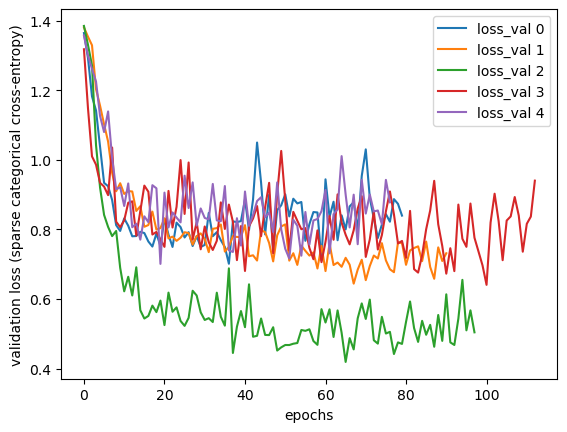

In [10]:
# plot learning curve
plt.figure()
plt.plot(results[0]['history']['val_loss'], label='loss_val 0')
plt.plot(results[1]['history']['val_loss'], label='loss_val 1')
plt.plot(results[2]['history']['val_loss'], label='loss_val 2')
plt.plot(results[3]['history']['val_loss'], label='loss_val 3')
plt.plot(results[4]['history']['val_loss'], label='loss_val 4')
plt.ylabel('validation loss (sparse categorical cross-entropy)')
plt.xlabel('epochs')
plt.legend()

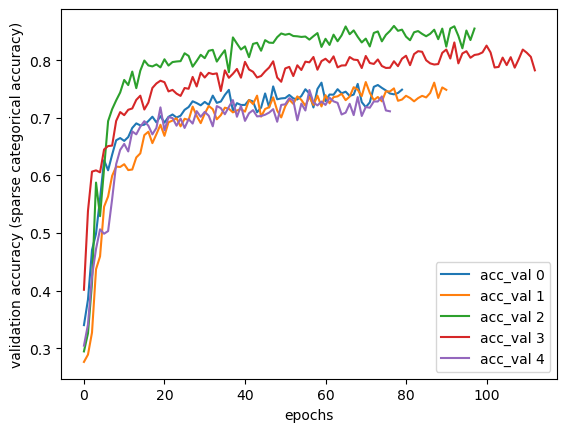

In [11]:
# plot learning curve
plt.figure()
plt.plot(results[0]['history']['val_sparse_categorical_accuracy'], label='acc_val 0')
plt.plot(results[1]['history']['val_sparse_categorical_accuracy'], label='acc_val 1')
plt.plot(results[2]['history']['val_sparse_categorical_accuracy'], label='acc_val 2')
plt.plot(results[3]['history']['val_sparse_categorical_accuracy'], label='acc_val 3')
plt.plot(results[4]['history']['val_sparse_categorical_accuracy'], label='acc_val 4')
plt.ylabel('validation accuracy (sparse categorical accuracy)')
plt.xlabel('epochs')
plt.legend()